In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline


In [2]:
 # Load the dataset
    
start_tok = '<S>'
end_tok = '<E>'
unk_tok = '<U>'
    
def load_dataset(file):
    reviews = open(file, 'r').read().splitlines()
    X = []
    Y = []
    for review in reviews:
        label, text = review.strip().split('|||')
        # Start and End tokens are added - in the final set, add space and unknown tokens as well
        X.append([ start_tok ] + text.strip().split(' ') + [ end_tok ])
        Y.append(int(label))
    return X, Y
        
Xtr, Ytr = load_dataset('data/sst-sentiment-text-threeclass/train.txt')
Xdev, Ydev = load_dataset('data/sst-sentiment-text-threeclass/dev.txt')
Xte, Yte = load_dataset('data/sst-sentiment-text-threeclass/test.txt')


In [3]:
import random
random.seed(42)

words = { word for x in Xtr for word in x }

stoi = {s:i+1 for i,s in enumerate(sorted(list(words)))}
stoi[unk_tok] = 0
itos = {i:s for s,i in stoi.items()}
wordset_size = len(itos)
print(wordset_size)



18283


In [4]:
readable_labels = {
    -1 : 'negative',
     0 : 'neutral',
     1 : 'positive'
}

readable_labels_size = len(readable_labels)

def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return torch.eye(num_classes, dtype=torch.float32)[y]

itol = { i:v for i,v in enumerate(readable_labels) }
ltoi = { v:i for i,v in itol.items() }
itoc = { i:to_categorical(l, num_classes=readable_labels_size) for i,l in itol.items()}
def ctoi(t):
    for i,c in itoc.items():
        if torch.equal(c,t):
            return i
    return -1

print(f'index to label (itol): {itol}')
print(f'label to index (ltoi): {ltoi}')
print(f'index to categorical (itoc): {itoc}')
print(f'categorical to index (ctoi): {ctoi(itoc[0])}')

index to label (itol): {0: -1, 1: 0, 2: 1}
label to index (ltoi): {-1: 0, 0: 1, 1: 2}
index to categorical (itoc): {0: tensor([0., 0., 1.]), 1: tensor([1., 0., 0.]), 2: tensor([0., 1., 0.])}
categorical to index (ctoi): 0


In [5]:
# build the dataset
block_size = 16

def build_dataset(X, Y):
    
    Xt, Yt = [], []
    stoi_keys = list(stoi.keys())
    
    for x,y in zip(X, Y):
        # padded context of zero tokens with block size expected
        context = [0] * block_size
        for i, w in enumerate(x):
            ix = stoi[w] if w in stoi_keys else 0
            if i > 1:
                Xt.append(context)
                Yt.append(itoc[ltoi[y]])
            context = context[1:] + [ix] #crop and append
        
    Xt = torch.tensor(Xt)
    Yt = torch.stack(Yt)
    print(Xt.shape, Yt.shape)
    return Xt, Yt

 
Xtr, Ytr = build_dataset(Xtr, Ytr)      #80%
Xdev, Ydev = build_dataset(Xdev, Ydev)  #10%
Xte, Yte = build_dataset(Xte, Yte)      #10%


torch.Size([163563, 16]) torch.Size([163563, 3])
torch.Size([21274, 16]) torch.Size([21274, 3])
torch.Size([42405, 16]) torch.Size([42405, 3])


In [6]:
# Pick ten samples in intervals to show the construction of XTr train set and YTr label set
for x,y in zip(Xtr[::Xtr.shape[0]//10], Ytr[::Ytr.shape[0]//10]):
    print(' '.join(itos[ix.item()] for ix in x), '--->', readable_labels[itol[ctoi(y)]])

<U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <S> The ---> positive
<U> <U> <U> <U> <U> <S> That old adage about women being unknowable gets an exhilarating ---> positive
<U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <S> The main problem being ---> neutral
all the emotional seesawing , it 's hard to figure the depth of these two literary ---> negative
<U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <S> Just watch Bettany strut his ---> neutral
<U> <U> <U> <U> <U> <U> <U> <U> <U> <S> Most of the problems with the ---> negative
<U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <S> The film feels formulaic ---> negative
where Ms. Shu is an institution , but American audiences will probably find it familiar and ---> negative
<U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <S> Alas ---> positive
Amish people alive in this situation better than these British soldiers do at keeping themselves kicking ---> negative
<U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <S> In this case ---> negativ

In [7]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # kaiming initialization for normalized variance
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# ---------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-6, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      dims = [d for d in range(0, x.dim() - 1)]
      xmean = x.mean(tuple(dims), keepdim=True) # batch mean
      xvar = x.var(tuple(dims), keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# ---------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# ---------------
class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
        
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
        
  def parameters(self):
    return [self.weight]

# ---------------
class FlattenConsecutive:
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []

# ---------------
class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [8]:
torch.manual_seed(42)

In [9]:
n_embd = 16
n_hidden = 64


model = Sequential([
    Embedding(wordset_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, readable_labels_size),
])

#parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 #last linear layer is reduced so that we make it less confident at the beginning
    
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

319859


In [10]:
# same optimization as last time
max_steps = 100000
batch_size = 32
lossi = []
lossv = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.01 if i > max_steps/3 else 0.1

  for p in parameters:
    p.data += -lr * p.grad
    
  with torch.no_grad():
    ix = torch.randint(0, Xdev.shape[0], (batch_size,))
    Xv, Yv = Xdev[ix], Ydev[ix]
    vlogits = model(Xv)
    l = F.cross_entropy(vlogits, Yv)
    lossv.append(l.log10().item())

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: loss(test): {loss.item():.4f} :loss(val): {l.item():.4f} : lr:{lr:.3f}' )
    
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])



      0/ 100000: loss(test): 1.1086 :loss(val): 1.0899 : lr:0.100
  10000/ 100000: loss(test): 1.0210 :loss(val): 1.1011 : lr:0.100
  20000/ 100000: loss(test): 0.8744 :loss(val): 1.0629 : lr:0.100
  30000/ 100000: loss(test): 0.8848 :loss(val): 1.1389 : lr:0.100
  40000/ 100000: loss(test): 0.9421 :loss(val): 1.0136 : lr:0.010
  50000/ 100000: loss(test): 0.6879 :loss(val): 1.1206 : lr:0.010
  60000/ 100000: loss(test): 0.8697 :loss(val): 1.1111 : lr:0.010
  70000/ 100000: loss(test): 0.6919 :loss(val): 1.3081 : lr:0.010
  80000/ 100000: loss(test): 0.7340 :loss(val): 1.3101 : lr:0.010
  90000/ 100000: loss(test): 0.7343 :loss(val): 1.1425 : lr:0.010


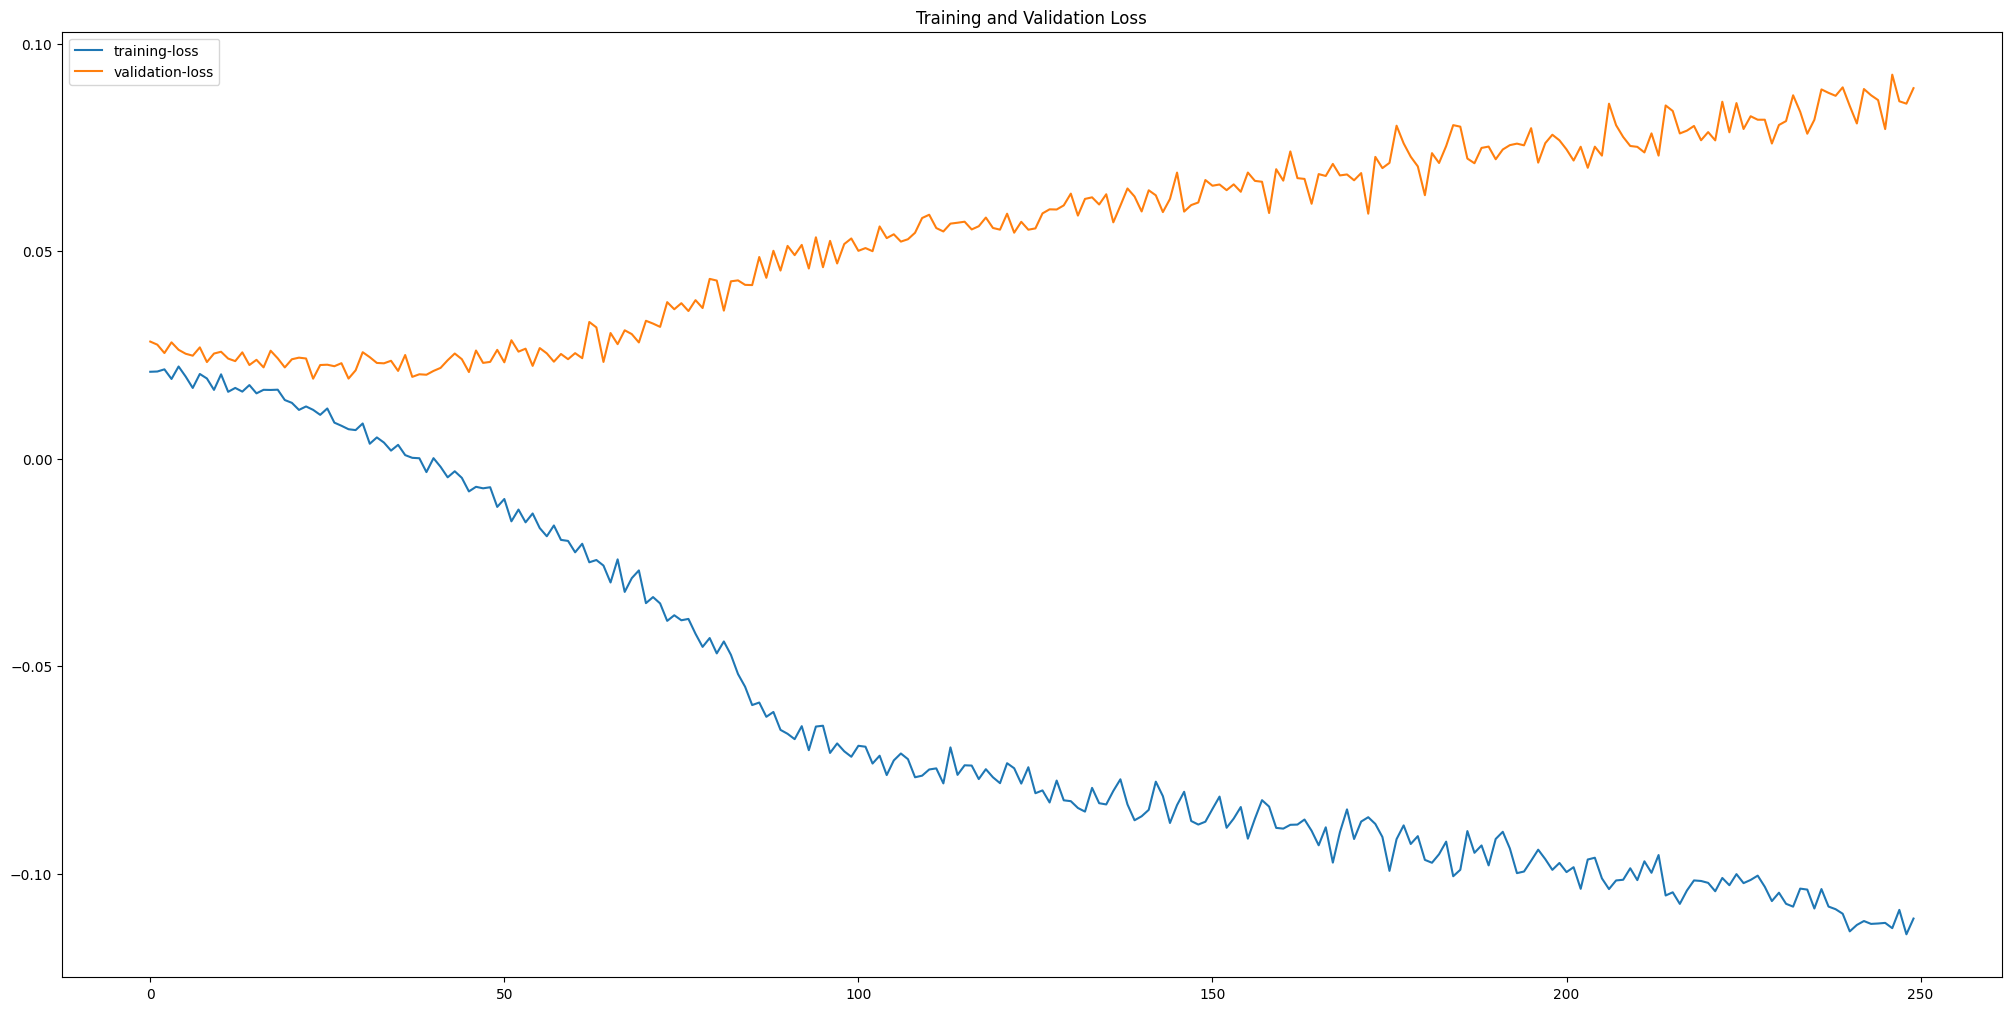

In [11]:
lvi = torch.tensor(lossi).view(-1,400).mean(1)
lvp = torch.tensor(lossv).view(-1,400).mean(1)


fig, ax = plt.subplots(figsize=(20, 10), layout='constrained')
ax.plot(lvi, label='training-loss')  
ax.plot(lvp, label='validation-loss')  
ax.set_title("Training and Validation Loss") 
ax.legend();  # Add a legend.

In [12]:
for layer in model.layers:
    layer.training = False
    


In [13]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # take 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb)
print(Yb)
print(logits)
Xb.shape, Yb.shape, logits.shape

tensor([[    0,     0,   231,  4459,    27, 11020, 13660, 18109, 12310, 10072,
         18249, 16414,  9424, 16658, 17024, 10310],
        [    0,     0,     0,     0,     0,   231,  4118, 14877, 11013,  4638,
         16825, 12694,    27, 18092,  9035, 12121],
        [    0,     0,     0,     0,     0,   231,   918, 14494, 16658,  9325,
         16657, 11682,  4118,  1739,  2854,  4638],
        [ 2143, 16658, 16835, 11013,  4638,  2283, 13907,    27, 16678, 16658,
          5121, 11975,  5582,  4637,  2094,  7974]])
tensor([[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]])
tensor([[-0.0553,  1.7332, -1.8204],
        [-0.4431, -0.7246,  1.1905],
        [-0.5783, -0.7520,  1.4571],
        [ 1.0636, -1.2782,  0.2116]], grad_fn=<AddBackward0>)


(torch.Size([4, 16]), torch.Size([4, 3]), torch.Size([4, 3]))

In [14]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))
    

Embedding : (4, 16, 16)
FlattenConsecutive : (4, 8, 32)
Linear : (4, 8, 64)
BatchNorm1d : (4, 8, 64)
Tanh : (4, 8, 64)
FlattenConsecutive : (4, 4, 128)
Linear : (4, 4, 64)
BatchNorm1d : (4, 4, 64)
Tanh : (4, 4, 64)
FlattenConsecutive : (4, 2, 128)
Linear : (4, 2, 64)
BatchNorm1d : (4, 2, 64)
Tanh : (4, 2, 64)
FlattenConsecutive : (4, 128)
Linear : (4, 64)
BatchNorm1d : (4, 64)
Tanh : (4, 64)
Linear : (4, 3)


In [15]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]

  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 0.7591066956520081
val 1.2216683626174927
test 1.1990143060684204


In [30]:
ix = torch.randint(0, Xte.shape[0], (5,)) # take 5 examples
Xc, Yc = Xte[ix], Yte[ix]

for x,y in zip(Xc, Yc):
    print(' '.join(itos[ix.item()] for ix in x), '--->', readable_labels[itol[ctoi(y)]])
    
logits = model(Xc)
probs = F.softmax(logits, dim=1)
print(logits)
print(probs)


of a departure from the noble characters he has played in the past , and he ---> positive
<U> <U> <S> What will , most likely , turn out to be the most repellent ---> negative
<U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <U> <S> As ---> negative
this uncompromising insight into the harsh existence of the <U> refugees of Iran 's <U> . ---> positive
<U> <U> <U> <U> <U> <S> Offers a breath of the fresh air of true sophistication ---> positive
tensor([[ 0.3825, -1.5453,  1.0264],
        [-0.6853, -0.6596,  1.3432],
        [-0.4867,  0.6397, -0.0253],
        [-1.1870,  0.4739,  0.5783],
        [-1.3740,  1.6619, -0.3508]], grad_fn=<AddBackward0>)
tensor([[0.3279, 0.0477, 0.6244],
        [0.1039, 0.1066, 0.7896],
        [0.1763, 0.5439, 0.2797],
        [0.0826, 0.4348, 0.4826],
        [0.0406, 0.8463, 0.1131]], grad_fn=<SoftmaxBackward0>)
